<a href="https://colab.research.google.com/github/meryemjabrane1/AlzNet-Federated/blob/NonAugmentedDataset/AlzNet_Federated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#installing packages
!pip install -q flwr[simulation] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.4 MB/s eta 0:00:00


In [3]:
#importing libraries
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
import torchvision.models as models
import os
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split, Dataset

from torchvision.datasets import ImageFolder
from PIL import Image

import flwr as fl
from flwr.common import Metrics

device = "cuda" if torch.cuda.is_available() else "cpu"
device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
#print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

In [11]:
CLASSES = (
    "MildDemented",
    "ModerateDemented",
    "NonDemented",
    "VeryMildDemented",
)

In [4]:
NUM_CLIENTS = 3
BATCH_SIZE = 64
NBR_CLASSES = 4
epochs = 5
num_rounds=3

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Defining Custom dataset class (still gotta know if its necessary or not)
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image


In [ ]:

!wget -O AugmentedAlzheimerDataset.zip https://dl.dropboxusercontent.com/s/g933yjln90vhrzk/AugmentedAlzheimerDataset.zip


In [ ]:
!unzip AugmentedAlzheimerDataset.zip -d destination_folder


In [13]:
def load_datasets():
    import os

    # Download and transform (train and test)
    transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

    root_dir = "/content/drive/MyDrive/dataset/Alzheimer_sDataset/train"
    print("Listing root directory contents:")
    print(os.listdir(root_dir))

    for class_name in ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']:
        class_dir = os.path.join(root_dir, class_name)
        print(f"Listing contents of {class_name} directory:")
        print(os.listdir(class_dir))

    # Load Dataset
    dataset = datasets.ImageFolder(root=root_dir, transform=transform)

    # Define Training and Testing Sets
    trainset_size=int(0.9*len(dataset))
    testset_size= len(dataset)-trainset_size
    train_dataset, test_dataset = random_split(dataset,[trainset_size,testset_size])

    # Split training set into 3 partitions to simulate the individual dataset
    partition_size = len(train_dataset) // NUM_CLIENTS
    lengths = [partition_size] * NUM_CLIENTS
    clientdatasets = random_split(train_dataset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in clientdatasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=BATCH_SIZE))
    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    return trainloaders, valloaders, testloader

trainloaders, valloaders, testloader = load_datasets()


Listing root directory contents:
['.DS_Store', 'VeryMildDemented', 'NonDemented', 'MildDemented', 'ModerateDemented']
Listing contents of MildDemented directory:
['mildDem123.jpg', 'mildDem608.jpg', 'mildDem183.jpg', 'mildDem460.jpg', 'mildDem129.jpg', 'mildDem232.jpg', 'mildDem17.jpg', 'mildDem221.jpg', 'mildDem702.jpg', 'mildDem399.jpg', 'mildDem156.jpg', 'mildDem121.jpg', 'mildDem493.jpg', 'mildDem642.jpg', 'mildDem422.jpg', 'mildDem450.jpg', 'mildDem325.jpg', 'mildDem426.jpg', 'mildDem346.jpg', 'mildDem558.jpg', 'mildDem297.jpg', 'mildDem199.jpg', 'mildDem699.jpg', 'mildDem90.jpg', 'mildDem16.jpg', 'mildDem235.jpg', 'mildDem679.jpg', 'mildDem8.jpg', 'mildDem46.jpg', 'mildDem428.jpg', 'mildDem545.jpg', 'mildDem289.jpg', 'mildDem75.jpg', 'mildDem359.jpg', 'mildDem538.jpg', 'mildDem326.jpg', 'mildDem595.jpg', 'mildDem586.jpg', 'mildDem688.jpg', 'mildDem34.jpg', 'mildDem86.jpg', 'mildDem274.jpg', 'mildDem547.jpg', 'mildDem162.jpg', 'mildDem56.jpg', 'mildDem553.jpg', 'mildDem126.jpg', '

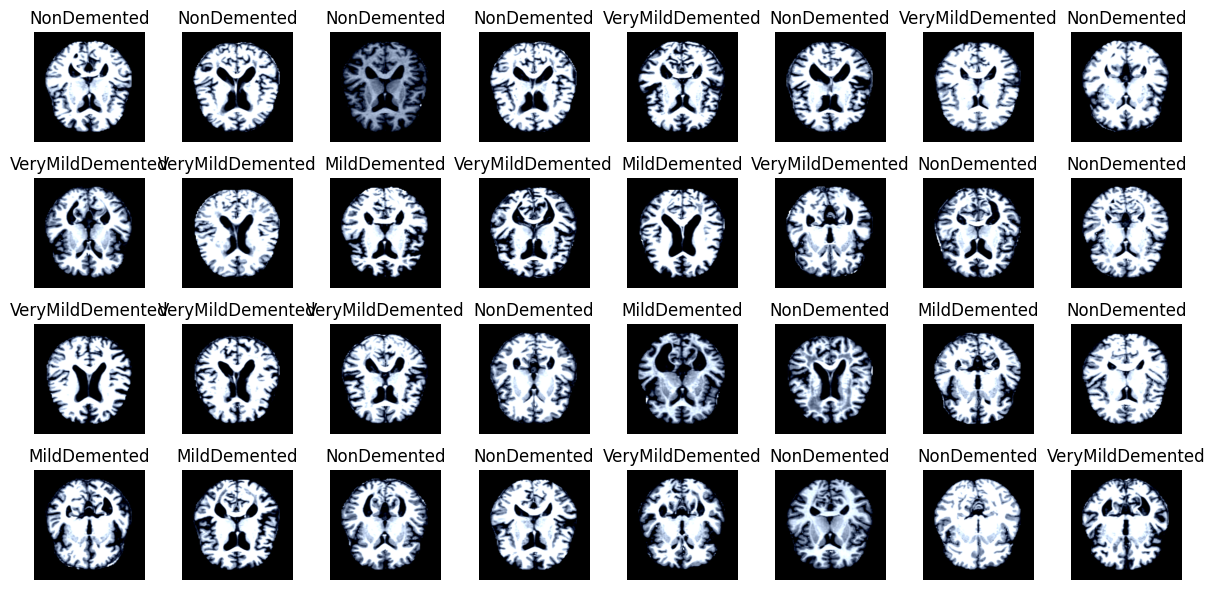

In [14]:
images, labels = next(iter(trainloaders[0]))

# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(CLASSES[labels[i]])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [ ]:
#define model architecture
model = models.densenet121(pretrained=True)
#model = models.densenet121(progress=True)
model.classifier = nn.Linear(1024, NBR_CLASSES)

In [17]:
# Load pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Freeze feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False
# Replace the last linear layer with a new one with the desired number of output classes
model.classifier = torch.nn.Linear(model.classifier[1].in_features, NBR_CLASSES)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [18]:

def train(model, trainloader, epochs: int, parameters: List[np.ndarray] = None):
    """Train the network on the training set."""
    model_parameters = [val.cpu().numpy() for _, val in model.state_dict().items()]

    if parameters is not None:
        for param in parameters:
            if param.size == 0:
                print("Empty numpy array found!")
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    model.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def test(model, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [19]:
trainloader = trainloaders[0]
valloader = valloaders[0]
model.to(device)

for epoch in range(epochs):
    train(model, trainloader, 1)
    loss, accuracy = test(model, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(model, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: train loss 0.016106005758047104, accuracy 0.5213304410701374
Epoch 1: validation loss 0.017418628035027996, accuracy 0.5424836601307189
Epoch 1: train loss 0.014512964524328709, accuracy 0.5762834417932032
Epoch 2: validation loss 0.015674250577789504, accuracy 0.6013071895424836
Epoch 1: train loss 0.013929665088653564, accuracy 0.5806218365871294
Epoch 3: validation loss 0.015380207230063045, accuracy 0.5816993464052288
Epoch 1: train loss 0.013257546350359917, accuracy 0.6240057845263919
Epoch 4: validation loss 0.015385800716923732, accuracy 0.5947712418300654
Epoch 1: train loss 0.01369549985975027, accuracy 0.5856832971800434
Epoch 5: validation loss 0.01489656657175301, accuracy 0.6143790849673203
Final test set performance:
	loss 0.013649630267717684
	accuracy 0.6335282651072125


In [20]:

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, trainloader, valloader):
        self.cid = cid
        self.model = model
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)
        train(self.model, self.trainloader, epochs=1)
        return self.get_parameters(config), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.model.load_state_dict(state_dict, strict=True)
        loss, accuracy = test(self.model, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

def client_fn(cid) -> FlowerClient:
    model_copy = models.densenet121(pretrained=True)
    model_copy.classifier = nn.Linear(1024, NBR_CLASSES)
    model_copy.to(device)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, model_copy, trainloader, valloader)


In [21]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [22]:
# The `evaluate` function will be by Flower called after every round

def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
    model,
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    print (f"-------/{server_round}/--------{config}")
    model = model.to(device)
    valloader = valloaders[0]

    # Set model parameters directly without calling set_parameters function
    for param in parameters:
        if param.size == 0:
            print("Empty numpy array found!")

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

    loss, accuracy = test(model, valloader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    torch.cuda.empty_cache()
    return loss, {"accuracy": accuracy}


In [23]:

def fit_config(server_round: int):
    """Return training configuration dict for each round.

    Perform two rounds of training with one local epoch, increase to two local
    epochs afterwards.
    """
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 if server_round < 2 else 2,  #
    }
    return config

In [25]:
# Create an instance of the model and get the parameters

model_parameters = [val.cpu().numpy() for _, val in model.state_dict().items()]
# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=fl.common.ndarrays_to_parameters(model_parameters),
    on_fit_config_fn=fit_config  # Pass the fit_config function
    # evaluate_fn=evaluate(server_round=0, parameters=model_parameters, config=fit_config(0), model=model),
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if device.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=2),  # six rounds
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-12-01 18:43:56,956 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
2023-12-01 18:44:01,420	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-01 18:44:03,932 | app.py:213 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3907826073.0, 'CPU': 2.0, 'memory': 7815652148.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 3907826073.0, 'CPU': 2.0, 'memory': 7815652148.0}
INFO flwr 2023-12-01 18:44:03,936 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html


(DefaultActor pid=23768) [Client 1] fit, config: {'server_round': 1, 'local_epochs': 1}


ERROR flwr 2023-12-01 18:44:12,908 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

(DefaultActor pid=23768) [Client 0] fit, config: {'server_round': 1, 'local_epochs': 1}


ERROR flwr 2023-12-01 18:44:13,306 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

(DefaultActor pid=23768) [Client 2] fit, config: {'server_round': 1, 'local_epochs': 1}


ERROR flwr 2023-12-01 18:44:13,798 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

(DefaultActor pid=23768) [Client 2] evaluate, config: {}


ERROR flwr 2023-12-01 18:44:14,243 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

(DefaultActor pid=23768) [Client 0] evaluate, config: {}


ERROR flwr 2023-12-01 18:44:14,670 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

(DefaultActor pid=23768) [Client 1] fit, config: {'server_round': 2, 'local_epochs': 2}


ERROR flwr 2023-12-01 18:44:16,543 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

(DefaultActor pid=23768) [Client 1] evaluate, config: {}


ERROR flwr 2023-12-01 18:44:17,024 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

(DefaultActor pid=23768) [Client 0] evaluate, config: {}


ERROR flwr 2023-12-01 18:44:17,494 | ray_client_proxy.py:145 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 138, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 414, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 300, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 252

(DefaultActor pid=23768) [Client 2] evaluate, config: {}
